## PDS Assignment

In [1]:
# Question 1
# Import required packages
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import warnings
from IPython.display import display, HTML
import re
import matplotlib.pyplot as plt

# To supress all warnings for visual clarity. Due to warnings resulting from using verifty = False in requests.get().
# For debugging comment out as this could hide crucial warnings. 
warnings.filterwarnings('ignore')

# Link for website main page 
main_page_url = "https://sitescrape.awh.durham.ac.uk/comp42315/"

# Start on main page because first page of publications url might change if a new topic of research is added  
# before "Animation and Graphics" in the future or if the "Animation and Graphics" name is changed slightly 
# e.g. "Animation, Graphics and Visualisation". More robust to start from the main page and find the provided 
# initial publications link from there. 
page = requests.get(main_page_url, verify = False)

soup = BeautifulSoup(page.content, "html.parser")


In [2]:
# Finds all the <a> tags which contain "publicationfull_type_" in the href. This start of the relative file path is 
# the same for all topics in the various publication topic pages and the href for this tag will give the first topic 
# page to start scraping from. 
publication_navigation_option = soup.find_all(name = "a", href = lambda href: href and "publicationfull_type_" in href)

# Check if no publication navigation option found 
if (len(publication_navigation_option) == 0):
    
    raise Exception("No publication navigation link found. Please investigate!")

# Check if more than one publication navigation option found 
if (len(publication_navigation_option) > 1):
    
    raise Exception("More than on publication navigation link found. Please investigate!")

# Select the one element of the publication_navigation_option list
publication_navigation_option = publication_navigation_option[0]

# Select the URL from the publication_navigation_option element 
publication_navigation_relative_url = publication_navigation_option.get("href")


In [3]:
# Concatinate main page url (global) and publication partial url (relative) to get global url for publications page
publication_navigation_full_url = main_page_url + publication_navigation_relative_url

# Scrape the initial publications page 
page = requests.get(publication_navigation_full_url, verify = False)

soup = BeautifulSoup(page.content, "html.parser")


In [4]:
# Find all links in the publications page which follow the topic page format 
# This finds the link for the current page from the PUBLICATIONS span and all other links from the Topic section 
publication_page_elements = soup.find_all(name = "a", href = lambda href: href and "publicationfull_type_" in href)

# Check if no publication page elements found 
if (len(publication_page_elements) == 0):
    
    raise Exception("No publication page elements found. Please investigate!")

publication_page_urls = []

# Loop through publication_page_elements and create a list of the topic page relative URLs 
for element in publication_page_elements:
    
    publication_page_urls.append(element.get("href"))
    

In [5]:
# Create empty dataframe with required column titles 
publications_dataframe = pd.DataFrame(columns = ["Publication Title", "Year", "Author List"])

# Loop through all topic pages and scrape 
for topic_relative_url in publication_page_urls:
    
    # Concatinate main page global URL and topic page relative URL to get topic page global URL 
    topic_global_url = main_page_url + topic_relative_url
    
    # Scrape topic page 
    page = requests.get(topic_global_url, verify = False)
    
    soup = BeautifulSoup(page.content, "html.parser")
    
    # Find all publications 
    publications = soup.find_all(name = "div", class_ = "w3-cell-row")
    
    # Check if no publications found 
    if (len(publications) == 0):
        
        raise Exception("No publications found in topic page. Please investigate!")
    
    publication_titles = []
    
    publication_years = []
    
    publication_authors = []
    
    # Loop through publications and collect publication title, year and authors for each 
    for publication in publications:
        
        # Find publication title 
        publication_title = publication.find_all(name = "span", class_ = "PublicationTitle")
        
        # Check if no publication title found 
        if (len(publication_title) == 0):
            
            raise Exception("Publication element has no title. Please investigate!")
            
        # Check if more than one publication title found 
        elif (len(publication_title) > 1):
                
            raise Exception("Publication element has more than one title. Please investigate!")
                
        else:
            
            # .contents[0] ensures that the additional text after publication titles is not include e.g. "Best Paper Award"
            publication_titles.append(publication_title[0].contents[0])
            
        # Find all TextSmalls elements 
        publication_TextSmalls = publication.find_all(name = "span", class_ = "TextSmall")
        
        # Check if less than expected (3) TextSmall elements found 
        if (len(publication_TextSmalls) < 3):
            
            raise Exception("Publication element has less tags of TextSmall class than anticipated. Please investigate!")
            
        # Check if more than expected (3) TextSmall elements found 
        elif (len(publication_title) > 3):
                
            raise Exception("Publication element has more tags of TextSmall class than anticipated. Please investigate!")
                
        else:
            
            # .rstrip() just in case there is a space at end of text as opposed to year - more robust 
            publication_years.append(publication_TextSmalls[0].text.rstrip()[-4:])
            
            publication_authors.append(publication_TextSmalls[1].text)
    
    # Create a dataframe for the ith topic 
    topic_i_dataframe = pd.DataFrame({"Publication Title" : publication_titles, 
                                      "Year" : publication_years, 
                                      "Author List" : publication_authors})
    
    # Add the ith topic dataframe to the publications dataframe 
    publications_dataframe = pd.concat([publications_dataframe, topic_i_dataframe], ignore_index = True)
    

In [6]:
# Create a column with the number of authors
publications_dataframe["Number of Authors"] = publications_dataframe["Author List"].str.replace(" and ", ", ").str.split(", ").apply(len)

# Remove rows with duplicate publication titles
unique_publications_dataframe = publications_dataframe.drop_duplicates(subset = "Publication Title")

# Sort dataframe by descending year, then descending no. of authors, then alphabetically by publication title 
unique_publications_dataframe = unique_publications_dataframe.sort_values(by = ["Year", "Number of Authors", "Publication Title"], ascending = [False, False, True])

# Add row numbers column starting from 1
unique_publications_dataframe.insert(0, "", range(1, len(unique_publications_dataframe) + 1))


In [7]:
# Display all rows in pandas dataframe
pd.set_option("display.max_rows", None)
# Display all columns in pandas dataframe
pd.set_option("display.max_columns", None)
# Display all text within cells in pandas dataframe
pd.set_option("display.max_colwidth", None)

# Display dataframe of unique publications which dynamically adjusts to screen size and 
# still displays all information excluding index column 
display(HTML(unique_publications_dataframe.to_html(index = False)))


,Publication Title,Year,Author List,Number of Authors
1,A Video-Based Augmented Reality System for Human-in-the-Loop Muscle Strength Assessment of Juvenile Dermatomyositis,2023,"Kanglei Zhou, Ruizhi Cai, Yue Ma, Qingqing Tan, Xinning Wang, Jianguo Li, Hubert P. H. Shum, Frederick W. B. Li, Song Jin and Xiaohui Liang",10
2,A Mixed Reality Training System for Hand-Object Interaction in Simulated Microgravity Environments,2023,"Kanglei Zhou, Chen Chen, Yue Ma, Zhiying Leng, Hubert P. H. Shum, Frederick W. B. Li and Xiaohui Liang",7
3,Correlation-Distance Graph Learning for Treatment Response Prediction from rs-fMRI,2023,"Xiatian Zhang, Sisi Zheng, Hubert P. H. Shum, Haozheng Zhang, Nan Song, Mingkang Song and Hongxiao Jia",7
4,Unaligned 2D to 3D Translation with Conditional Vector-Quantized Code Diffusion using Transformers,2023,"Abril Corona-Figueroa, Sam Bond-Taylor, Neelanjan Bhowmik, Yona Falinie A. Gaus, Toby P. Breckon, Hubert P. H. Shum and Chris G. Willcocks",7
5,Region-Based Appearance and Flow Characteristics for Anomaly Detection in Infrared Surveillance Imagery,2023,"Yona Falinie A. Gaus, Neelanjan Bhowmik, Brian K. S. Isaac-Medina, Hubert P. H. Shum, Amir Atapour-Abarghouei and Toby P. Breckon",6
6,Hard No-Box Adversarial Attack on Skeleton-Based Human Action Recognition with Skeleton-Motion-Informed Gradient,2023,"Zhengzhi Lu, He Wang, Ziyi Chang, Guoan Yang and Hubert P. H. Shum",5
7,Focalized Contrastive View-Invariant Learning for Self-Supervised Skeleton-Based Action Recognition,2023,"Qianhui Men, Edmond S. L. Ho, Hubert P. H. Shum and Howard Leung",4
8,Hierarchical Graph Convolutional Networks for Action Quality Assessment,2023,"Kanglei Zhou, Yue Ma, Hubert P. H. Shum and Xiaohui Liang",4
9,INCLG: Inpainting for Non-Cleft Lip Generation with a Multi-Task Image Processing Network,2023,"Shuang Chen, Amir Atapour-Abarghouei, Edmond S. L. Ho and Hubert P. H. Shum",4
10,Interaction-Aware Decision-Making for Automated Vehicles using Social Value Orientation,2023,"Luca Crosato, Hubert P. H. Shum, Edmond S. L. Ho and Chongfeng Wei",4


[Explain your design and highlight any features in this question’s report part of your Jupyter Notebook in no more than 300 words. (35%)]

**Design:**
The script begins by scraping the website main page for the URL to the initial publications page, checking for links containing "publicationfull_type_". It is assumed "publicationfull_type_" will be in the initial publications page URL in the future. This is more robust than starting from a specific topic URL as the topic category names in the publications page could change causing a hardcoded URL to fail. 

The script then scrapes the initial publications page for the relative URLs to every publications topic page, checking for links containing "publicationfull_type_". "publicationfull_type_" is unique to topic page URLs and it is assumed this will be the case in the future. This is more robust than using a hardcoded list of topic page URLs as it deals with the case where topic categories are added or changed. 

The script then combines the main_page_url with each relative topic page URL and scrapes each of the topic pages, checking for div tags with class "w3-cell-row". The "w3-cell-row" class is unique to the publication elements required to be scraped, it is assumed this will be the case in the future. It is assumed that the combined topic pages are exhaustive and any additional future publications will be either assigned to a current, new or altered topic. 

The publication title, year and author list are extracted from each publication element. 

This data is then processed and presented as specified. 

**Features:**
As little as possible is hardcoded e.g. the main_page_url is defined in the first chunk and then all relative urls are concatinated with the main_page_url when required later in the script. This makes the code more robust only requiring the main_page_url to be updated in the first chunk if it changes in the future. 

Checks are implemented throughout the script to ensure the correct data type, length of lists, etc. are returned from each stage, with error messages printed if not. This improves robustness and informs the user if the script is malfuncitoning in some way which might not be immediately obvious. 

Find all is used as opposed to find to allow for checks on the number of items returned in the list from find all, checking if the tag has not been found at all or if it has been found more times than expected. 

Using soup as the variable for each scraped page to continually overwrite as opposed to use more memory. 

In [8]:
# Question 2
# Concatinate main page url (global) and publication partial url (relative) to get global url for publications page 
publication_navigation_full_url = main_page_url + publication_navigation_relative_url

# Scrape the initial publications page 
page = requests.get(publication_navigation_full_url, verify = False)

soup = BeautifulSoup(page.content, "html.parser")


In [9]:
publication_topics = []

# Loop through publication_page_elements and create a list of topic names 
for element in publication_page_elements:
    
    publication_topics.append(element.contents[0])

# Use regex to find the element which contains "Topic:" in it's text. This is required because the first element 
# in publication_page_elements is the PUBLICATIONS element which is okay for getting the link to the current page, 
# as in Question 1, but this element doesn't contain the current page topic name 
match = re.search(r":\s*(.*?)\s*/", soup.find(string = lambda text: "Topic:" in text).parent.text)

# Check if a match was found from re.search-ing for the regex in the parent.text of the element 
# The regex searches for : followed by any characters followed by / to find our current topic name 
if (match):
    
    # Assign the current topic name to first_topic 
    first_topic = match.group(1)
    
else:
    
    raise Exception("No first topic found. Please investigate!")

# Overwrite the first topic (invalid as described above) with the correct first_topic in the 
# publication_topics list 
publication_topics[0] = first_topic


In [10]:
# TODO: Name all variables which are used from Question 1? Or copy all code from Question 1 repeated for ease of marking 

# Create empty dataframe with required column titles 
journal_papers_dataframe = pd.DataFrame(columns = ["Publication Title", "Year", "Number of Citations", "Topic", "LDOR"])

# Loop through all topic pages and scrape 
for i, topic_relative_url in enumerate(publication_page_urls):
    
    # Concatinate main page global URL and topic page relative URL to get topic page global URL 
    topic_global_url = main_page_url + topic_relative_url
    
    # Scrape topic page 
    page = requests.get(topic_global_url, verify = False)
    
    soup = BeautifulSoup(page.content, "html.parser")
    
    # Find journal header element 
    journal_headers = soup.find_all(name = "h2", id = "Journal Papers")
    
    # Check if more than one journal header found 
    if (len(journal_headers) > 1):
        
        raise Exception("More than one Journal Papers header found. Please investigate!")
    
    # Skip to the next iteration of the for loop (the next topic page) if there is no journal header 
    # present in the current topic page 
    if (len(journal_headers) < 1):
        
        continue
    
    journal_header = journal_headers[0]
    
    # Find next div element after journal header 
    journal_div = journal_header.find_next_sibling(name = "div")
    
    # Find all journal papers 
    journal_papers = journal_div.find_all(name = "div", class_ = "w3-cell-row")
    
    # Check if no journal papers found 
    if (len(journal_papers) == 0):
        
        raise Exception("No journal papers found in topic page. Please investigate!")
    
    journal_paper_titles = []
    
    journal_paper_years = []
    
    journal_paper_ncitations = []
    
    journal_paper_topics = []
    
    journal_paper_ldors = []
    
    # Loop through journal_papers and collect publication title and year for each 
    for journal_paper in journal_papers:
        
        # Find journal paper title 
        journal_paper_title = journal_paper.find_all(name = "span", class_ = "PublicationTitle")
        
        # Check if no journal paper title found 
        if (len(journal_paper_title) == 0):
            
            raise Exception("Publication element has no title. Please investigate!")
        
        # Check if more than one journal paper title found 
        elif (len(journal_paper_title) > 1):
                
            raise Exception("Publication element has more than one title. Please investigate!")
                
        else:
            
            # .contents[0] ensures that the additional text after publication titles is not include e.g. "Best Paper Award"
            journal_paper_titles.append(journal_paper_title[0].contents[0])
            
        # Find all TextSmalls elements 
        journal_paper_TextSmalls = journal_paper.find_all(name = "span", class_ = "TextSmall")
        
        # Check if less than expected (3) TextSmall elements found 
        if (len(journal_paper_TextSmalls) < 3):
            
            raise Exception("Publication element has less tags of TextSmall class than anticipated. Please investigate!")
            
        # Check if more than expected (3) TextSmall elements found 
        elif (len(journal_paper_TextSmalls) > 3):
            
            raise Exception("Publication element has more tags of TextSmall class than anticipated. Please investigate!")
            
        else:
            
            # .rstrip() just in case there is a space at end of text as opposed to year
            journal_paper_years.append(journal_paper_TextSmalls[0].text.rstrip()[-4:])
        
        # Add row of journal_paper_topics as value of ith publication_topics 
        journal_paper_topics.append(publication_topics[i])
        
        # Find relative URL for journal paper page 
        journal_paper_relative_url = journal_paper_TextSmalls[2].find(name = "a", class_ = "LinkButton").get("href")
        
        # Concatinate main page global URL and journal paper page relative URL to get journal paper page global URL 
        journal_paper_global_url = main_page_url + journal_paper_relative_url
        
        # Scrape journal paper page 
        page = requests.get(journal_paper_global_url, verify = False)
        
        soup = BeautifulSoup(page.content, "html.parser")
        
        # Find citation element 
        citation_text = soup.find(string = lambda text: "Citation:" in text)
        
        # Check if no citations found 
        if (citation_text == None):
            
            # If no citation found assign n_citations a value of 0 
            n_citations = 0
        
        else:
            
            # If citation found use regex to find number of citations between Citation: and ## 
            match = re.search(r"Citation:(.*?)##", citation_text.parent.text)
            
            # Assign the number of citations to n_citations 
            n_citations = match.group(1)
        
        journal_paper_ncitations.append(n_citations)
        
        # Find the LDORs element 
        ldor_header = soup.find(name = "h2", text = "Links, Downloads and Online Resources")
        
        # Check if no LDORs header found 
        if (ldor_header ==  None):
        
            # If no LDORs header found assign n_ldors a value of 0  
            n_ldors = 0
            
        else:
            
            # If LDORs header found find next div element after LDORs header
            ldors = ldor_header.find_next_sibling(name = "div")
            
            # Find the number of links by using the fact that each has an individual thumb nail 
            links = len(ldors.find_all(name = "div", class_ = "ImgThumbnailDiv"))
            
            # Find the number of embedded youtube videos 
            yt_vids = len(ldors.find_all(class_ = "youtube-player"))
            
            # Sum the number of links and embedded youtube videos to get LDORs value 
            n_ldors = links + yt_vids
    
        journal_paper_ldors.append(n_ldors)
    
    # Create a dataframe for the ith topic 
    topic_i_dataframe = pd.DataFrame({"Publication Title" : journal_paper_titles, 
                                      "Year" : journal_paper_years, 
                                      "Number of Citations" : journal_paper_ncitations,
                                      "Topic" : journal_paper_topics,
                                      "LDOR" : journal_paper_ldors})
    
    # Add the ith topic dataframe to the journal papers dataframe 
    journal_papers_dataframe = pd.concat([journal_papers_dataframe, topic_i_dataframe], ignore_index = True)
    

In [11]:
# TODO: Work out what question means bt filtering for unique values because this doesn't make sense 
# when calculating grouped statistics 

# Remove rows with duplicate publication titles grouped by topic - currently none but more robust 
unique_journal_papers_dataframe_bytopic = journal_papers_dataframe.drop_duplicates(subset = ["Topic", "Publication Title"])

# Remove rows with duplicate publication titles 
unique_journal_papers_dataframe = journal_papers_dataframe.drop_duplicates(subset = "Publication Title")

# Convert Number of Citations and LDOR columns to integers in the relevant deduplicated vs deduplicated by group dataframes
unique_journal_papers_dataframe_bytopic["Number of Citations"] = pd.to_numeric(unique_journal_papers_dataframe_bytopic["Number of Citations"], errors = "coerce")

unique_journal_papers_dataframe["Number of Citations"] = pd.to_numeric(unique_journal_papers_dataframe["Number of Citations"], errors = "coerce")
unique_journal_papers_dataframe["LDOR"] = pd.to_numeric(unique_journal_papers_dataframe["LDOR"], errors = "coerce")

# TODO: Remove before submitting 
display(HTML(unique_journal_papers_dataframe_bytopic.to_html(index = False)))

Publication Title,Year,Number of Citations,Topic,LDOR
A Video-Based Augmented Reality System for Human-in-the-Loop Muscle Strength Assessment of Juvenile Dermatomyositis,2023,2,Animation and Graphics,4
GAN-based Reactive Motion Synthesis with Class-aware Discriminators for Human-human Interaction,2022,9,Animation and Graphics,4
Spatio-temporal Manifold Learning for Human Motions via Long-horizon Modeling,2021,68,Animation and Graphics,4
A Quadruple Diffusion Convolutional Recurrent Network for Human Motion Prediction,2021,16,Animation and Graphics,5
A Generic Framework for Editing and Synthesizing Multimodal Data with Relative Emotion Strength,2019,5,Animation and Graphics,4
Multi-layer Lattice Model for Real-Time Dynamic Character Deformation,2015,25,Animation and Graphics,4
Human Motion Variation Synthesis with Multivariate Gaussian Processes,2014,7,Animation and Graphics,4
Topology Aware Data-Driven Inverse Kinematics,2013,26,Animation and Graphics,5
Natural Preparation Behavior Synthesis,2013,2,Animation and Graphics,4
Simulating Multiple Character Interactions with Collaborative and Adversarial Goals,2012,48,Animation and Graphics,7


In [12]:
print(journal_papers_dataframe.shape)
print(unique_journal_papers_dataframe_bytopic.shape)
print(unique_journal_papers_dataframe.shape)

(94, 5)
(94, 5)
(68, 5)


In [13]:
# Create citations table with mean and sample variance by topic 
citations_dataframe = unique_journal_papers_dataframe_bytopic.groupby("Topic")["Number of Citations"].agg(["mean", "var"])

# Fill NaNs with 0 - NaNs for variance appear because variance is trying to be calculated over one value 
citations_dataframe = citations_dataframe.fillna(0)

# Round mean and var columns to 1 decimal place 
citations_dataframe = citations_dataframe.round({"mean" : 1, "var" : 1})

# Rename columns 
citations_dataframe.rename(columns = {"mean" : "Mean Number of Citations per Journal Paper",
                                      "var" : "Variance of Citations per Journal Paper"})


,Mean Number of Citations per Journal Paper,Variance of Citations per Journal Paper
Topic,,
3D Surfaces,13.4,74.8
Action Recognition,35.0,1289.0
Animation and Graphics,25.7,842.8
Biomedical Engineering,33.9,2448.1
Biometrics,16.4,314.0
Computational Intelligence,18.0,223.0
Crowd Simulation,15.4,139.3
Depth and 3D Estimation,59.4,4432.8
Facial Feature Analysis,10.0,74.5


In [14]:
# Figure 1

citations_dataframe_fig1 = unique_journal_papers_dataframe_bytopic.groupby(["Year"])["Number of Citations"].agg(["mean", "var"])

# Fill NaNs with 0 - NaNs for variance appear because variance is trying to be calculated over one value 
citations_dataframe_fig1 = citations_dataframe_fig1.fillna(0)

# Round mean and var columns to 1 decimal place 
citations_dataframe_fig1 = citations_dataframe_fig1.round({"mean" : 1, "var" : 1})

citations_dataframe_fig1


,mean,var
Year,,
2008,87.0,75.0
2009,8.0,0.0
2011,11.0,0.0
2012,48.0,0.0
2013,56.5,6057.0
2014,17.0,200.0
2015,25.0,0.0
2016,51.5,629.7
2017,70.9,7858.5


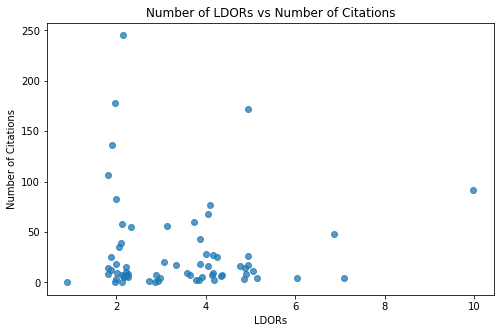

In [15]:
# Figure 2

np.random.seed(123)

plt.figure(figsize = (8, 5))
# Jitter the LDORs values to prevent overplotting 
plt.scatter(unique_journal_papers_dataframe["LDOR"] + np.random.normal(0, 0.15, size = unique_journal_papers_dataframe["LDOR"].shape), 
            unique_journal_papers_dataframe["Number of Citations"], alpha = 0.75)
plt.title("Number of LDORs vs Number of Citations")
plt.xlabel("LDORs")
plt.ylabel("Number of Citations")

plt.show()


[Explain your design and highlight any features in this question’s report part of your Jupyter Notebook in no more than 300 words. (35%)]

**Design:**
It was decided that, although it is possible to fully combine the scripts for Questions 1 and 2 and have slightly less scraping traffic for the website, that for the purposes of this exercise a clear distinction between questions would ease interpretability for marking. 

The script begins by using the URL for the initial publications page scraped in question 1. This page is then scraped to get a list of topics, locating tags by searching for links containing "publicationfull_type_" and collecting the topic text. This strategy, while effective for Question 1, doesn't yield the first topic due to the current topic page you're on not having a link in the topics section. regex was used to locate the current page's topic and add as the first topic list item. 

publication_page_urls was used from Question 1 to loop through and scrape each topic page. An initial check is implemented for if the topic page contains a Journal Papers section, with topic pages not containing skippped. Each tag corresponding to individual journal papers is then scraped from the topic page. These journal paper elements are then looped through, with publication title and year collected and the corresponding publication topic taken from the topics list. The relative URL for each of the individual journal paper pages is taken and combined with the main_page_url. Each individual journal paper page is then scraped to collect the number of citations: using regex, and the number of LDORs: calculated as the number of LDOR links present and the number of YouTube videos embeded, ensuring not to double count the dynamic thumbnail image links. Both citations and LDORs are given values of 0 if the corresponding section is not present. 

The process is then repeated looping through every available topic page, with all collected data for each topic page combined into a dataframe and appened to the overall dataframe. 

Two versions of this dataframe are then created: one deduplicated with respect to Publication Title and one grouped by Topic and deduplicated with respect to Publication Title, due to Figure 1 requiring the latter and Figure 2 requiring the former. 

This data is then processed and presented as specified. 

Note: In Figure 2 LDOR values are jittered to aid visual interpretability. 

In [16]:
# Question 3 

# Import required packages 
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sklearn
from IPython.display import display, HTML
from pgmpy.models import BayesianNetwork, BayesianModel
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator, ExpectationMaximization, MaximumLikelihoodEstimator
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


In [17]:
# Import data 
finance_data = pd.read_csv("finance_dataset.csv", sep = ",", header = 0)

# Define required columns 
required_columns = ["high52", "mom12m", "mom6m", "maxret", "mom12moffseason", "realizedvol", 
                   "idiovolaht", "zerotrade", "indretbig", "returnskew", "excessret"]

# Filter for required columns 
finance_data = finance_data[required_columns]

finance_data.head()


,high52,mom12m,mom6m,maxret,mom12moffseason,realizedvol,idiovolaht,zerotrade,indretbig,returnskew,excessret
0,0.763581,-0.142394,0.171635,-0.017522,-0.007751,-0.010742,-0.014408,2.166704e-08,-0.005455,-0.288199,-0.051002
1,0.890511,-0.050934,0.043362,-0.033333,-0.014398,-0.012257,-0.033105,1.539724e-07,0.047533,-0.434343,0.073005
2,0.998534,0.088313,0.236039,-0.046931,0.037398,-0.015928,-0.025991,1.070238e-08,0.065702,-0.885588,0.064222
3,1.012490,-0.028781,0.341710,-0.031073,0.048832,-0.017873,-0.030543,1.178551e-08,0.029277,-0.263758,0.041555
4,0.516684,-0.374121,-0.043011,-0.061966,-0.056335,-0.024555,-0.042944,4.140273e-08,0.102665,-0.946360,0.147376


In [18]:
finance_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
high52,500.0,0.822815,0.181922,2.392638e-01,7.080895e-01,8.573567e-01,9.437912e-01,1.382140
mom12m,500.0,-0.019889,0.371154,-7.329010e-01,-2.476829e-01,-6.681741e-02,1.125461e-01,2.063720
mom6m,500.0,0.108378,0.255572,-4.090231e-01,-4.321944e-02,6.338909e-02,2.279047e-01,1.580645
maxret,500.0,-0.054409,0.036996,-3.477538e-01,-6.634666e-02,-4.352695e-02,-3.118531e-02,-0.006076
mom12moffseason,500.0,0.018903,0.039558,-9.176746e-02,-5.117328e-03,1.181651e-02,3.721887e-02,0.190136
realizedvol,500.0,-0.023312,0.011748,-8.981903e-02,-2.847900e-02,-2.097717e-02,-1.539543e-02,-0.004757
idiovolaht,500.0,-0.026259,0.013266,-1.273456e-01,-3.273918e-02,-2.303390e-02,-1.735720e-02,-0.009000
zerotrade,500.0,0.002000,0.021008,1.553084e-09,1.148040e-08,1.827145e-08,2.750040e-08,0.333333
indretbig,500.0,0.046176,0.053658,-8.933780e-02,8.375047e-03,3.814942e-02,7.783812e-02,0.250519
returnskew,500.0,-0.213726,0.787538,-4.160548e+00,-6.019183e-01,-2.079657e-01,1.627917e-01,3.283018


In [19]:
# Define lables for destritsed cartagories 
high52_labels = ["1.", "2.", "3.", "4."]
mom12m_labels = ["1.", "2.", "3.", "4."]
mom6m_labels = ["1.", "2.", "3.", "4."]
maxret_labels = ["1.", "2.", "3.", "4."]
mom12moffseason_labels = ["1.", "2.", "3.", "4."]
realizedvol_labels = ["1.", "2.", "3.", "4."]
idiovolaht_labels = ["1.", "2.", "3.", "4."]
zerotrade_labels = ["1.", "2.", "3.", "4."]
indretbig_labels = ["1.", "2.", "3.", "4."]
returnskew_labels = ["1.", "2.", "3.", "4."]
excessret_labels = ["1.", "2.", "3.", "4."]


In [20]:
# Define function to descritise data 
def make_discrete(df):
    
    discrete_df = pd.DataFrame()
    
    quantiles = [0, 0.25, 0.50, 0.75, 1]
    
    discrete_df["high52"] = pd.qcut(df["high52"], q = quantiles, labels = high52_labels, precision = 2)
    discrete_df["mom12m"] = pd.qcut(df["mom12m"], q = quantiles, labels = mom12m_labels, precision = 2)
    discrete_df["mom6m"] = pd.qcut(df["mom6m"], q = quantiles, labels = mom6m_labels, precision = 2)
    discrete_df["maxret"] = pd.qcut(df["maxret"], q = quantiles, labels = maxret_labels, precision = 2)
    discrete_df["mom12moffseason"] = pd.qcut(df["mom12moffseason"], q = quantiles, labels = mom12moffseason_labels, precision = 2)
    discrete_df["realizedvol"] = pd.qcut(df["realizedvol"], q = quantiles, labels = realizedvol_labels, precision = 2)
    discrete_df["idiovolaht"] = pd.qcut(df["idiovolaht"], q = quantiles, labels = idiovolaht_labels, precision = 2)
    discrete_df["zerotrade"] = pd.qcut(df["zerotrade"], q = quantiles, labels = zerotrade_labels, precision = 2)
    discrete_df["indretbig"] = pd.qcut(df["indretbig"], q = quantiles, labels = indretbig_labels, precision = 2)
    discrete_df["returnskew"] = pd.qcut(df["returnskew"], q = quantiles, labels = returnskew_labels, precision = 2)
    
    discrete_df["excessret"] = df["excessret"].apply(lambda x: "1" if x > 0 else "0")

    discrete_df = discrete_df.astype("object")

    return discrete_df


In [21]:
# Descritise data into catagories 
cat_finance_data = make_discrete(finance_data)

cat_finance_data.head(5)

,high52,mom12m,mom6m,maxret,mom12moffseason,realizedvol,idiovolaht,zerotrade,indretbig,returnskew,excessret
0,2.,2.,3.,4.,1.,4.,4.,3.,1.,2.,0
1,3.,3.,2.,3.,1.,4.,1.,4.,3.,2.,1
2,4.,3.,4.,2.,4.,3.,2.,1.,3.,1.,1
3,4.,3.,4.,4.,4.,3.,2.,2.,2.,2.,1
4,1.,1.,2.,2.,1.,2.,1.,4.,4.,1.,1


In [22]:
# Print counts of catagories 
for column in cat_finance_data:
    
    print(cat_finance_data.groupby(column)[column].count().reset_index(name = "Count").to_dict(orient = "records"))

[{'high52': '1.', 'Count': 125}, {'high52': '2.', 'Count': 125}, {'high52': '3.', 'Count': 125}, {'high52': '4.', 'Count': 125}]
[{'mom12m': '1.', 'Count': 125}, {'mom12m': '2.', 'Count': 125}, {'mom12m': '3.', 'Count': 125}, {'mom12m': '4.', 'Count': 125}]
[{'mom6m': '1.', 'Count': 125}, {'mom6m': '2.', 'Count': 125}, {'mom6m': '3.', 'Count': 125}, {'mom6m': '4.', 'Count': 125}]
[{'maxret': '1.', 'Count': 125}, {'maxret': '2.', 'Count': 125}, {'maxret': '3.', 'Count': 125}, {'maxret': '4.', 'Count': 125}]
[{'mom12moffseason': '1.', 'Count': 125}, {'mom12moffseason': '2.', 'Count': 125}, {'mom12moffseason': '3.', 'Count': 125}, {'mom12moffseason': '4.', 'Count': 125}]
[{'realizedvol': '1.', 'Count': 125}, {'realizedvol': '2.', 'Count': 125}, {'realizedvol': '3.', 'Count': 125}, {'realizedvol': '4.', 'Count': 125}]
[{'idiovolaht': '1.', 'Count': 125}, {'idiovolaht': '2.', 'Count': 125}, {'idiovolaht': '3.', 'Count': 125}, {'idiovolaht': '4.', 'Count': 125}]
[{'zerotrade': '1.', 'Count':

In [23]:
# Creat training and testing datasets - 25 / 75 test / train split 
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(cat_finance_data, test_size = 0.25, random_state = 123)


In [24]:
# Use Hill Climb Search to create a DAG 
# Instantiate Hill Climb Search 
hill_climb = HillClimbSearch(data = training_data)
# Instantiate estimator 
estimate = hill_climb.estimate(scoring_method = "k2score")


  0%|          | 0/1000000 [00:00<?, ?it/s]

In [25]:
# Generate Bayesian Network using the DAG 
model = BayesianNetwork(estimate)

In [26]:
# Fit Bayesian Network model to the data to create probability distributions 
# Disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

# Conditional Probability Distribution 
model.cpds = []

# Fit model 
model.fit(data = training_data,
    estimator = BayesianEstimator,
    prior_type = "BDeu",
    complete_samples_only = True)


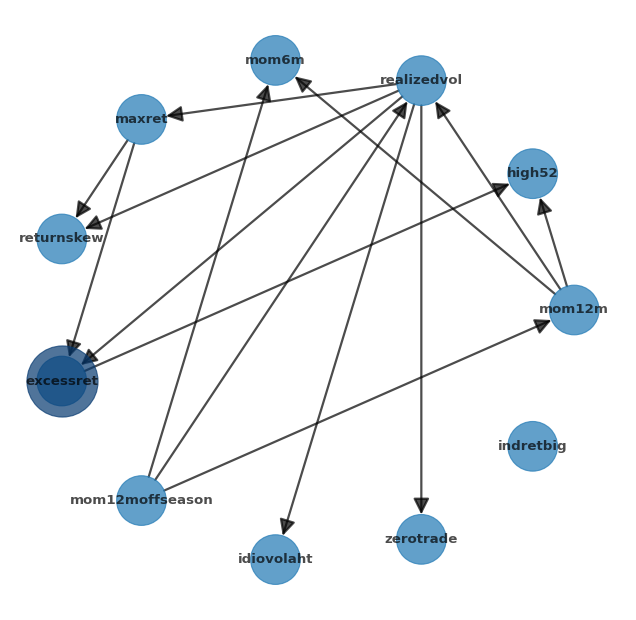

In [27]:
# Plot the model as a DAG 
plt.figure(3, figsize = (10, 10), dpi = 80) 
G = nx.DiGraph()
G.add_edges_from(model.edges)

G.add_nodes_from(model.nodes)
pos = nx.circular_layout(G)
DAG = G.to_directed()
nx.topological_sort(DAG)

nx.draw_networkx(G,
                pos = pos,
                with_labels = True,
                node_size = [2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000],
                arrowsize = 30,
                alpha = 0.7,
                font_weight = "bold",
                width = 2.0) 

tt_g = G.subgraph(nodes = ["excessret"])
nx.draw(tt_g, pos = pos, with_labels = False, arrowsize = 0, node_size = 4100, alpha = 0.7, font_weight = "bold", node_color = "#063970")

# Dependancies for outcome 
plt.show()

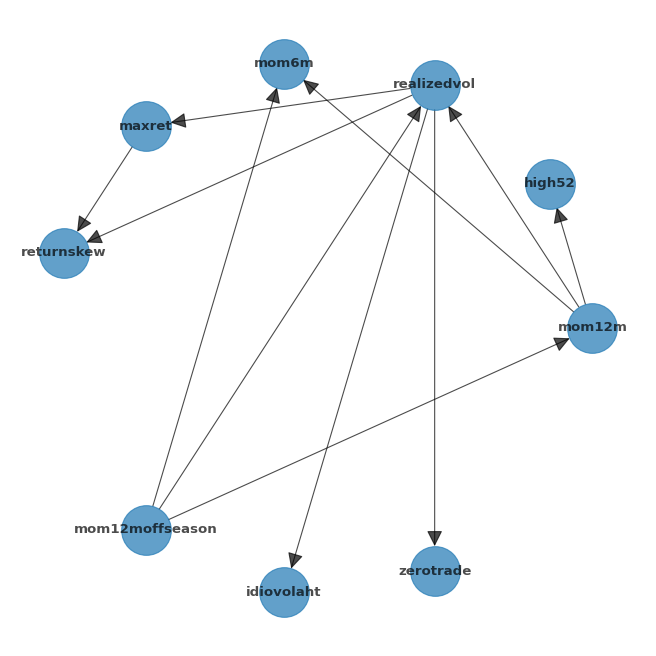

In [28]:
plt.figure(3, figsize = (8, 8), dpi = 80) 

sub_g = G.subgraph(nodes = ["high52", "mom12m", "mom6m", "maxret", "mom12moffseason", "realizedvol", 
                            "idiovolaht", "zerotrade", "returnskew"])
nx.draw(sub_g, pos = pos, with_labels = True, arrowsize = 30, node_size = 2000, alpha = 0.7, font_weight = "bold")

# Dependancies between none outcome features - dependant on each other 
plt.show()

In [29]:
testing_data.head()

,high52,mom12m,mom6m,maxret,mom12moffseason,realizedvol,idiovolaht,zerotrade,indretbig,returnskew,excessret
229,4.,3.,3.,1.,3.,2.,2.,4.,3.,1.,1
337,3.,4.,4.,1.,4.,1.,1.,2.,3.,3.,0
327,1.,2.,2.,3.,1.,4.,4.,4.,1.,1.,1
416,4.,4.,4.,3.,3.,3.,3.,3.,1.,4.,1
306,2.,2.,2.,4.,2.,3.,4.,4.,1.,4.,1


In [30]:
# Calculate prediction accuracy scores for all features 

accuracy_dict = {}

for column in testing_data:
    
    predict_data = testing_data.copy()
    predict_data.drop(column, axis = 1, inplace = True)
    y_pred = model.predict(predict_data)
    
    accuracy = accuracy_score(testing_data[column], y_pred)
    
    print(f'{column} Accuracy score: {accuracy}')

    accuracy_dict[column] = accuracy
    

  0%|          | 0/125 [00:00<?, ?it/s]

high52 Accuracy score: 0.6


  0%|          | 0/125 [00:00<?, ?it/s]

mom12m Accuracy score: 0.68


  0%|          | 0/125 [00:00<?, ?it/s]

mom6m Accuracy score: 0.536


  0%|          | 0/125 [00:00<?, ?it/s]

maxret Accuracy score: 0.688


  0%|          | 0/125 [00:00<?, ?it/s]

mom12moffseason Accuracy score: 0.552


  0%|          | 0/125 [00:00<?, ?it/s]

realizedvol Accuracy score: 0.688


  0%|          | 0/125 [00:00<?, ?it/s]

idiovolaht Accuracy score: 0.552


  0%|          | 0/124 [00:00<?, ?it/s]

zerotrade Accuracy score: 0.384


  0%|          | 0/124 [00:00<?, ?it/s]

indretbig Accuracy score: 0.2


  0%|          | 0/123 [00:00<?, ?it/s]

returnskew Accuracy score: 0.448


  0%|          | 0/125 [00:00<?, ?it/s]

excessret Accuracy score: 0.768


In [31]:
# Model accuracy for predicting whether the firm will make a profit or a loss 
print("Model accuracy for predicting if the firm will make a profit or loss:", round(accuracy_dict["excessret"], 2))


Model accuracy for predicting if the firm will make a profit or loss: 0.77


In [32]:
# Model performance metrics 
f1 = correlation_score(model = model, data = testing_data, test = "chi_square", significance_level = 0.05, score = f1_score, return_summary = False)
acc = correlation_score(model = model, data = testing_data, test = "chi_square", significance_level = 0.05, score = accuracy_score, return_summary = False)
pr = correlation_score(model = model, data = testing_data, test = "chi_square", significance_level = 0.05, score = precision_score, return_summary = False)
recall = correlation_score(model = model, data = testing_data, test = "chi_square", significance_level = 0.05, score = recall_score, return_summary = False)
ls = log_likelihood_score(model = model, data = testing_data)
ss = structure_score(model = model, data = testing_data, scoring_method = "bdeu")

print(f'F1 score: {round(f1, 2)}')
print(f'Accuracy score: {round(acc, 2)}')
print(f'Precision score: {round(pr, 2)}')
print(f'Recall score: {round(recall, 2)}')
print(f'Log-likilihood score: {round(ls, 2)}')
print(f'Structure score: {round(ss, 2)}')


F1 score: 0.5
Accuracy score: 0.64
Precision score: 1.0
Recall score: 0.33
Log-likilihood score: -1525.41
Structure score: -1691.04
